In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
%store -r data
%store -r target

In [3]:
data = standardize(data)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(data,target)

X_train shape: (8091, 51)
X_test shape: (999, 51)
X_val shape: (900, 51)
y_train shape: (8091,)
y_test shape: (999,)
y_val shape: (900,)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [4]:
model_bg = GradientBoostingClassifier()
model_bg.fit(X_dev, y_dev)
predsDevbg = model_bg .predict(X_dev)
predsTestbg = model_bg .predict(X_test)

In [5]:
testbg_score =  accuracy_score(y_test, predsTestbg )
devbg_score = accuracy_score(y_dev, predsDevbg )

In [6]:
print("Classification Score for Gradient Boosting Classifier on Dev dataset:\n")
print("Dev Score : ", devbg_score)
print(classification_report(y_dev, predsDevbg ))
print("--------------------------------------------------------")
print("Classification Score for Gradient Boosting Classifier on Test dataset:\n")
print("Test Score :", testbg_score)
print(classification_report(y_test, predsTestbg ))

Classification Score for Gradient Boosting Classifier on Dev dataset:

Dev Score :  0.9423868312757202
              precision    recall  f1-score   support

       blues       0.95      0.95      0.95       904
   classical       0.99      1.00      0.99       894
     country       0.88      0.93      0.90       886
       disco       0.90      0.93      0.92       890
      hiphop       0.96      0.93      0.94       901
        jazz       0.96      0.98      0.97       886
       metal       0.96      0.98      0.97       923
         pop       0.96      0.96      0.96       896
      reggae       0.93      0.92      0.93       904
        rock       0.92      0.86      0.89       907

    accuracy                           0.94      8991
   macro avg       0.94      0.94      0.94      8991
weighted avg       0.94      0.94      0.94      8991

--------------------------------------------------------
Classification Score for Gradient Boosting Classifier on Test dataset:

Test Scor

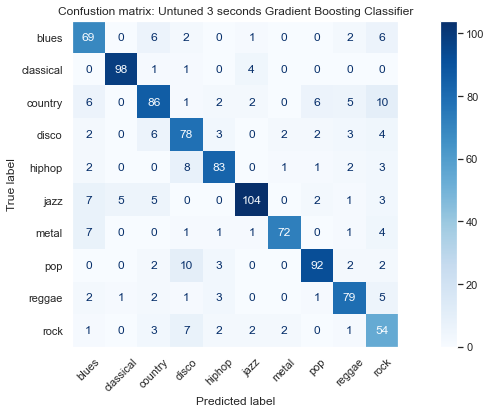

Accuracy : 0.82
Macro F-1 Score : 0.81


In [7]:
# Evaluate Model on Test set
class_labels = list(model_bg .classes_)
macro_f1, accuracy = evaluate_model(predsTestbg , y_test, class_labels,
                                    'Confustion matrix: Untuned 3 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [8]:
parameters = {"n_estimators": [100],
             "learning_rate": [0.1],
             "max_depth": [2]}
print(parameters)

{'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [2]}


In [9]:
tune_bg = GridSearchCV(estimator = model_bg , param_grid = parameters, cv = 5)
tune_bg .fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1], 'max_depth': [2],
                         'n_estimators': [100]})

In [10]:
print("Best Score :", tune_bg .best_score_)
print("Best Parameters :",tune_bg .best_params_)

Best Score : 0.7686579678118051
Best Parameters : {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [11]:
predsDevbg_tuned = tune_bg .predict(X_dev)
predsTestbg_tuned = tune_bg .predict(X_test)

print("Score on Dev data for GB using GridSearchCV:", accuracy_score(y_dev, predsDevbg_tuned))
print("Score on Test data for GB using GridSearchCV:",accuracy_score(y_test, predsTestbg_tuned))

Score on Dev data for GB using GridSearchCV: 0.847291736180625
Score on Test data for GB using GridSearchCV: 0.7747747747747747


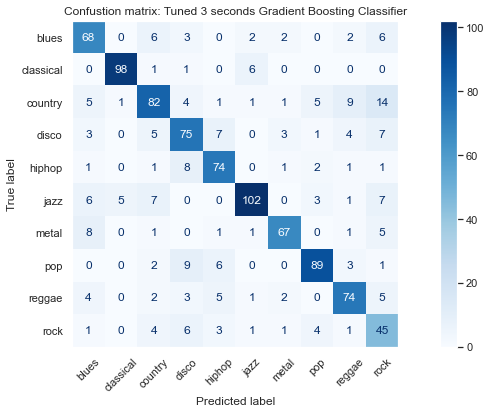

Accuracy : 0.77
Macro F-1 Score : 0.77


In [12]:
# Evaluate Model on Test set
class_labels = list(model_bg.classes_)
macro_f1, accuracy = evaluate_model(predsTestbg_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 3 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [13]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.11454404 0.08920634 0.04504717 0.02937379 0.02274578 0.0199205
 0.01584086 0.01368273 0.01132293 0.01090893 0.0089262  0.008148
 0.00722978 0.006841   0.00622568 0.00604713 0.00535512 0.00529876
 0.00508255 0.00483055 0.00472004 0.00416819 0.00364309 0.00346754
 0.00329374 0.00305647 0.00283172 0.0028055  0.00272337 0.00267825]
Sum of Explained Variance: 0.9367555355446446


In [14]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.262197,-0.041290,-0.004825,0.077376,-0.092648,-0.202191,0.134129,-0.029625,0.065913,0.012872,...,-0.036174,0.006731,-0.061828,-0.059013,-0.028870,0.007228,0.008474,-0.011543,-0.033081,blues
1,0.911816,0.656705,0.093061,0.041841,0.162397,-0.345908,-0.111054,0.005563,0.107247,0.058343,...,0.019154,-0.115378,0.035055,0.040330,0.019628,-0.065485,0.061125,0.107006,-0.041207,pop
2,-0.346865,0.190015,-0.015068,-0.042262,0.002093,-0.081458,-0.064497,-0.077140,-0.020671,-0.082200,...,-0.023231,0.040604,0.011014,-0.002285,0.058084,-0.027746,-0.032872,0.001861,-0.041115,rock
3,0.165602,-0.054123,-0.230414,-0.096289,0.254820,0.184295,-0.224987,0.077994,-0.083905,-0.040332,...,0.059563,0.028109,0.055530,0.006686,-0.009250,0.024950,-0.128474,-0.013741,-0.067677,jazz
4,-0.213596,0.153496,0.162250,0.171556,0.164250,-0.038909,0.033234,0.036496,0.089940,0.132925,...,0.094207,0.053053,0.073860,-0.043314,-0.004000,-0.051011,-0.031059,0.001339,-0.033112,hiphop


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [15]:
model_pca = GradientBoostingClassifier()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainbg = model_pca.predict(pca_data)
pcaTestbg = model_pca.predict(pca_data_test)

In [16]:
pcatestbg_score =  accuracy_score(y_test, pcaTestbg )
pcabg_score = accuracy_score(y_dev, pcaTrainbg )

In [17]:
print("Classification Score for Gradient Boosting Classifier on Train dataset:\n")
print("Train Score : ", pcabg_score)
print("--------------------------------------------------------")
print("Classification Score for Gradient Boosting Classifier on Test dataset:\n")
print("Test Score :", pcatestbg_score)

Classification Score for Gradient Boosting Classifier on Train dataset:

Train Score :  0.8980091202313425
--------------------------------------------------------
Classification Score for Gradient Boosting Classifier on Test dataset:

Test Score : 0.7687687687687688


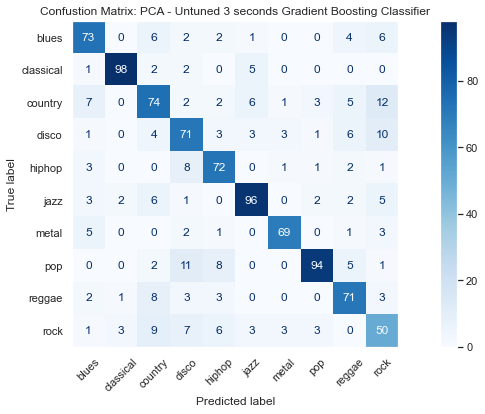

Accuracy : 0.77
Macro F-1 Score : 0.77


In [18]:
# Evaluate Model
class_labels = list(model_bg.classes_)
macro_f1, accuracy = evaluate_model(pcaTestbg , y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 3 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [19]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.262197,-0.041290,-0.004825,0.077376,-0.092648,-0.202191,0.134129,-0.029625,0.065913,0.012872,...,-0.010694,-0.036174,0.006731,-0.061828,-0.059013,-0.028870,0.007228,0.008474,-0.011543,-0.033081
1,0.911816,0.656705,0.093061,0.041841,0.162397,-0.345908,-0.111054,0.005563,0.107247,0.058343,...,0.005720,0.019154,-0.115378,0.035055,0.040330,0.019628,-0.065485,0.061125,0.107006,-0.041207
2,-0.346865,0.190015,-0.015068,-0.042262,0.002093,-0.081458,-0.064497,-0.077140,-0.020671,-0.082200,...,-0.048911,-0.023231,0.040604,0.011014,-0.002285,0.058084,-0.027746,-0.032872,0.001861,-0.041115
3,0.165602,-0.054123,-0.230414,-0.096289,0.254820,0.184295,-0.224987,0.077994,-0.083905,-0.040332,...,-0.024257,0.059563,0.028109,0.055530,0.006686,-0.009250,0.024950,-0.128474,-0.013741,-0.067677
4,-0.213596,0.153496,0.162250,0.171556,0.164250,-0.038909,0.033234,0.036496,0.089940,0.132925,...,-0.050657,0.094207,0.053053,0.073860,-0.043314,-0.004000,-0.051011,-0.031059,0.001339,-0.033112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8986,0.223969,0.199646,-0.304657,0.107035,0.128513,-0.077396,0.112849,-0.020105,-0.039329,0.079148,...,-0.060823,0.003197,0.040761,0.021165,0.063788,-0.028173,0.039881,0.039102,0.063542,0.022351
8987,-0.606602,0.172697,-0.153625,0.181308,-0.121462,0.157417,0.025890,0.059123,-0.051089,-0.138438,...,-0.001494,-0.033512,-0.048761,0.008717,-0.006889,-0.021434,-0.017758,-0.055512,-0.011313,0.033932
8988,-0.049191,0.533015,0.390142,-0.164059,0.121950,0.004290,0.132511,-0.029937,0.190393,0.052240,...,0.007944,0.096575,0.104159,-0.004468,0.012859,0.102521,-0.002843,-0.112942,-0.043599,0.052002
8989,0.060511,-0.364952,-0.044975,-0.081345,-0.295758,-0.073172,-0.190965,-0.031111,-0.108377,0.086472,...,-0.088329,-0.008649,0.000354,-0.065136,-0.042640,0.149462,0.014413,-0.033779,-0.028007,-0.030350


In [20]:
model_pca_tuned = tune_bg 
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainbg_tuned = model_pca_tuned.predict(pca_data)
pcaTestbg_tuned = model_pca_tuned.predict(pca_data_test)

In [21]:
pcatestbg_score =  accuracy_score(y_test, pcaTestbg_tuned)
pcabg_score = accuracy_score(y_dev, pcaTrainbg_tuned)

In [22]:
print("Classification Score for GradientBoostingClassifier on Train dataset:\n")
print("Train Score : ", pcabg_score)
print("--------------------------------------------------------")
print("Classification Score for GradientBoostingClassifier on Test dataset:\n")
print("Test Score :", pcatestbg_score)

Classification Score for GradientBoostingClassifier on Train dataset:

Train Score :  0.7883438994550106
--------------------------------------------------------
Classification Score for GradientBoostingClassifier on Test dataset:

Test Score : 0.7267267267267268


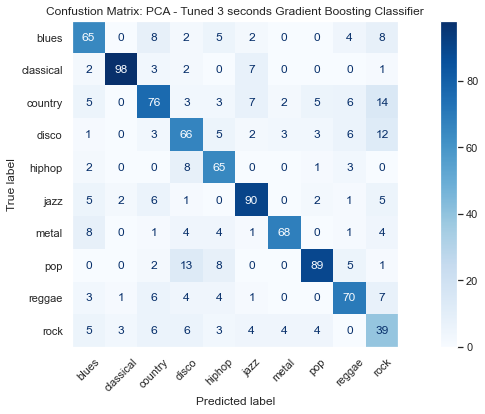

Accuracy : 0.73
Macro F-1 Score : 0.72


In [23]:
# Evaluate Model
class_labels = list(model_bg.classes_)
macro_f1, accuracy = evaluate_model(pcaTestbg_tuned, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 3 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)